In [1]:
# IMPORTING LIBRARIES

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import os
import warnings
warnings.filterwarnings("ignore")

from matplotlib import pyplot as plt
from sklearn.datasets.samples_generator import make_blobs
from sklearn.metrics.pairwise import cosine_similarity
import librosa
from IPython.display import Audio


In [2]:
# IMPORTING FILES

features = pd.read_csv(os.path.join("../","fma_metadata", "features.csv"), index_col=[0], header=[0,1,2])
tracks = pd.read_csv(os.path.join("../", "fma_metadata", "tracks.csv"), index_col=[0], header=[0,1])
genres = pd.read_csv(os.path.join("../", "fma_metadata", "genres.csv"))
sampled_features = pd.read_csv(os.path.join("../data/","sampled_features.csv"), index_col=[0], header=[0,1,2])
sampled_features.columns = [' '.join(col).strip() for col in sampled_features.columns.values]
g = 'genre Unnamed: 519_level_1 Unnamed: 519_level_2'

In [8]:
# REDUCING THE DATA USING UMAP

import umap.umap_ as umap
import seaborn as sns
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
just_stats = sampled_features.drop(g,axis=1)
scaled_stats = scaler.fit_transform(sampled_features.drop(g,axis=1))

reducer = umap.UMAP()
embedding = reducer.fit_transform(scaled_stats)
embedding.shape

just_stats['umap1'] = embedding[:,0]
just_stats['umap2'] = embedding[:,1]
just_stats['genre'] = sampled_features[g]
just_stats = just_stats[['umap1','umap2','genre']]
scaled_stats = just_stats
for_clustering = scaled_stats[['umap1', 'umap2']]

In [9]:
# TRAINING THE AgglomerativeClustering MODEL WITH 4 CLUSTERS

from sklearn.cluster import AgglomerativeClustering
Agglomerative = AgglomerativeClustering(n_clusters=4).fit(for_clustering)
scaled_stats['cluster'] = Agglomerative.labels_
groups = scaled_stats.groupby('cluster')
for name, group in groups:
    print("cluster num {}: {} items".format(name, len(group)))

cluster num 0: 462 items
cluster num 1: 399 items
cluster num 2: 570 items
cluster num 3: 169 items


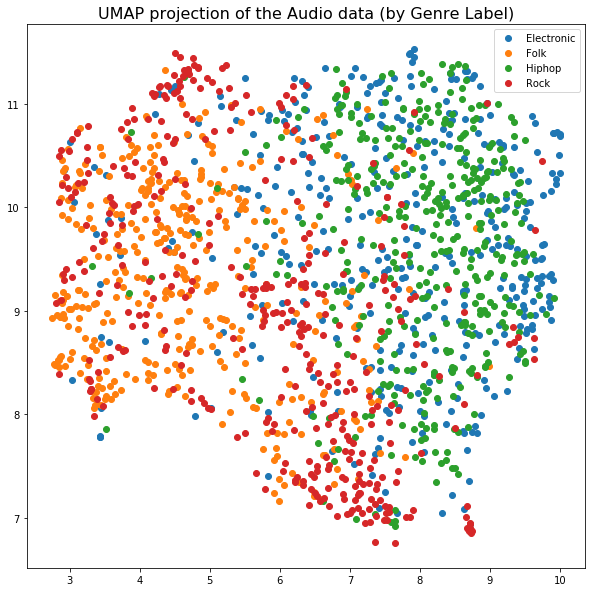

In [10]:
# PLOTTING THE DISTRIBUTION OF SAMPLES

groups = scaled_stats.groupby('genre')
fig, ax = plt.subplots(figsize=(10,10))
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.umap1, group.umap2, marker='o', linestyle='', label=name)
plt.title('UMAP projection of the Audio data (by Genre Label)', fontsize=16);
ax.legend()
plt.show()

In [11]:
# PLOTTING THE CLUSTERED RESULTS USING EXPRESS PLOTLY LIBRARY

res_df = scaled_stats[['genre','umap1','umap2']]
res_df['track_id'] = res_df.index

res_df['new_label'] = Agglomerative.labels_
res_df['new_label'] = res_df['new_label'].astype(str)
res_df['x'] = res_df['umap1'] - min(res_df['umap1'])
res_df['y'] = res_df['umap2'] - min(res_df['umap2'])
import plotly.express as px
px.scatter(res_df, x="x", y="y", color="new_label", hover_name="track_id", hover_data=["genre"],marginal_y="violin",
           marginal_x="box")


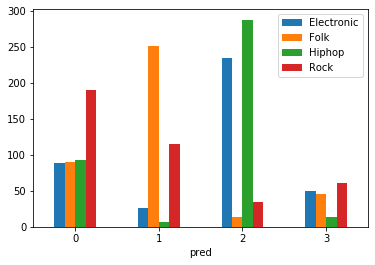

In [12]:
# SHOWING THE DISTRIBUTION OF ORIGINAL GENRES IN OUR CLUSTERS

n_sample = 400
results = pd.DataFrame()
results['genre'] = res_df['genre']
results = pd.get_dummies(results['genre'])
results['pred'] = Agglomerative.labels_
results = results.groupby(['pred']).sum()
results.plot.bar(rot=0)